In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib
%matplotlib notebook
import pandas as pd

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter(x, y, bins=50, xlim=None, ylim=None, filename=None):
    fig = plt.figure(figsize=(10, 10))
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
import matplotlib.animation as animation

In [65]:
def get_image_data(filename, gamma=0.6, debug=False, hide_max=False, logscale=False):
    with open(filename, "rb") as f:
        image_size = np.fromfile(f, dtype=np.int32, count=2)
        extent = np.fromfile(f, dtype=np.float32, count=4)
        image = np.fromfile(f, dtype=np.int32).reshape(image_size).T.astype(np.float)

        if (debug):
            _all = image.shape[0] * image.shape[1]
            _z = image[image == 0].shape[0]
            print(f"{filename}")
            print(f"\tzeros: {_z} ({100 * _z/_all}%)")
            print(f"\tmean & std: {np.mean(image)} +- {np.std(image)}")
            print(f"\ttotal_rays: {np.sum(image)}")

        img = np.zeros_like(image)
        if gamma is not None:
            img[image > 0] = image[image > 0]**gamma
        if logscale is not None and logscale:
            img[image > 0] = np.log10(image[image > 0])
        if img[img == np.max(img)].shape[0] < 5 and hide_max:
            img[img == np.max(img)] = np.mean(img) # removing center-of-mass pixel with extreame amplification
        return img, extent

def get_lc_data(filename):
    data = np.loadtxt(filename)
    return pd.DataFrame(data=data.copy(), columns=["t", "y1", "y2", "a_ad", "a_gs", "a_ld", "a_pl", "a_el", "a_el_orth"])

In [171]:
rays_y = np.loadtxt("./output/test/rays_0.00.dat")

<IPython.core.display.Javascript object>


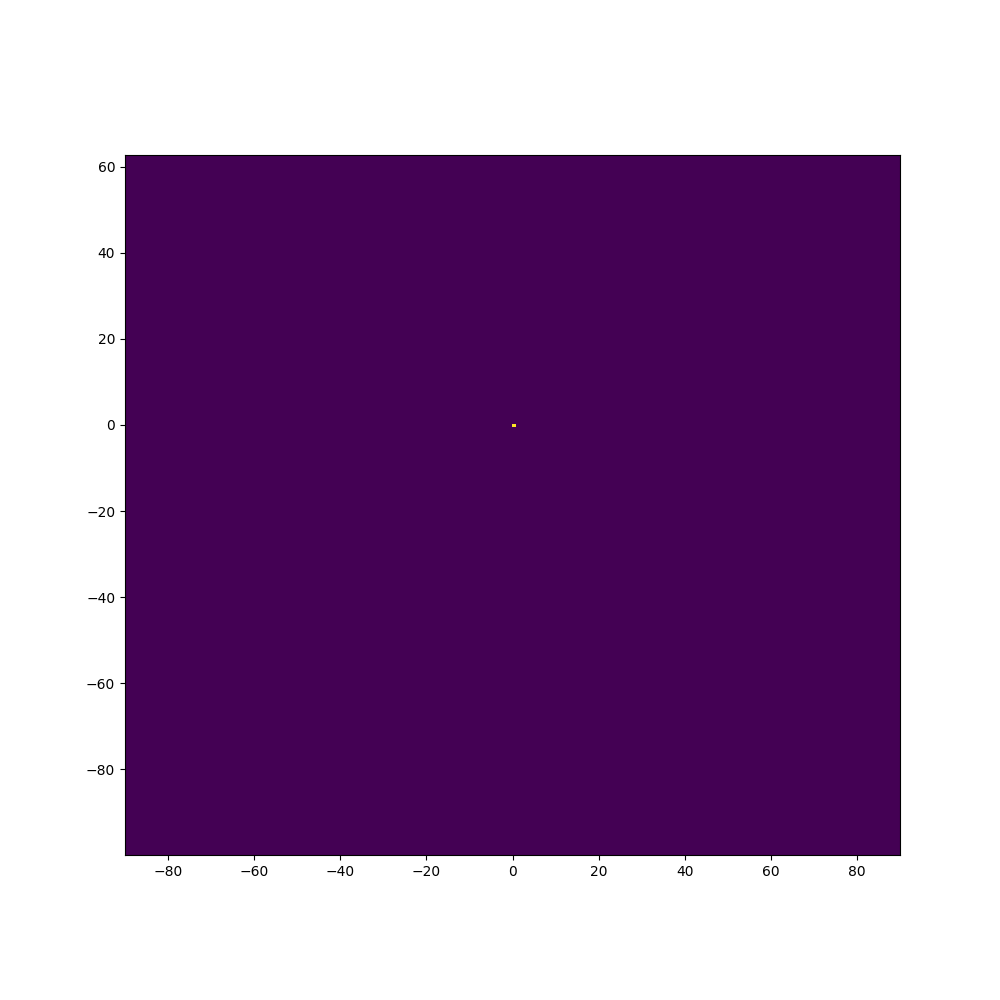

In [172]:
m = np.logical_and(np.abs(rays_y[:,0]) <= 100, np.abs(rays_y[:,1]) <= 100)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])

output/test1234567890/image_0.00.dat
	zeros: 61781 (6.1781%)
	mean & std: 1.85777 +- 1.8356504643041385
	total_rays: 1857770.0
output/test1234567890/image_0.00.dat
	zeros: 61781 (6.1781%)
	mean & std: 1.85777 +- 1.8356504643041385
	total_rays: 1857770.0


<IPython.core.display.Javascript object>


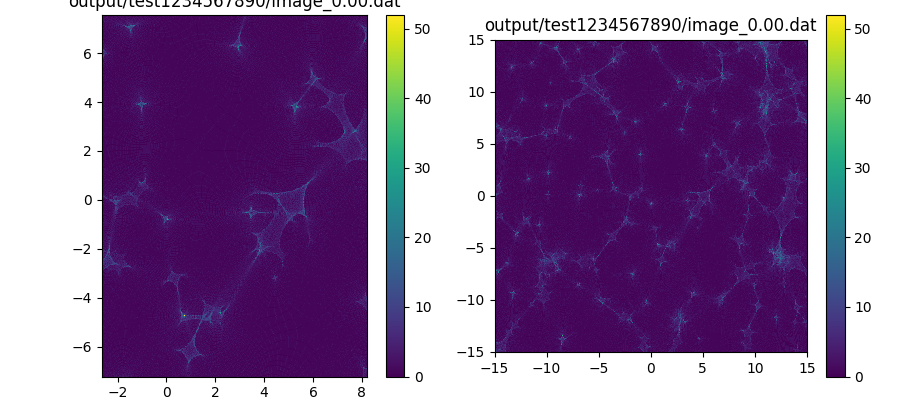

In [5]:
filename1 = "output/test1234567890/image_0.00.dat"
filename2 = "output/test1234567890/image_0.00.dat"

img1, extent1 = get_image_data(filename1, gamma=1, debug=True)
img2, extent2 = get_image_data(filename2, gamma=1, debug=True)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='none', extent=extent1, origin='lower')
pos2 = ax2.imshow(img2, interpolation='none', extent=extent2, origin='lower')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.colorbar(pos2, ax=ax2)
fig.tight_layout()
plt.show()

output/reference/image_0.00.dat
	zeros: 500668 (50.0668%)
	mean & std: 0.664888 +- 0.8913977492993799
	total_rays: 664888.0


<IPython.core.display.Javascript object>


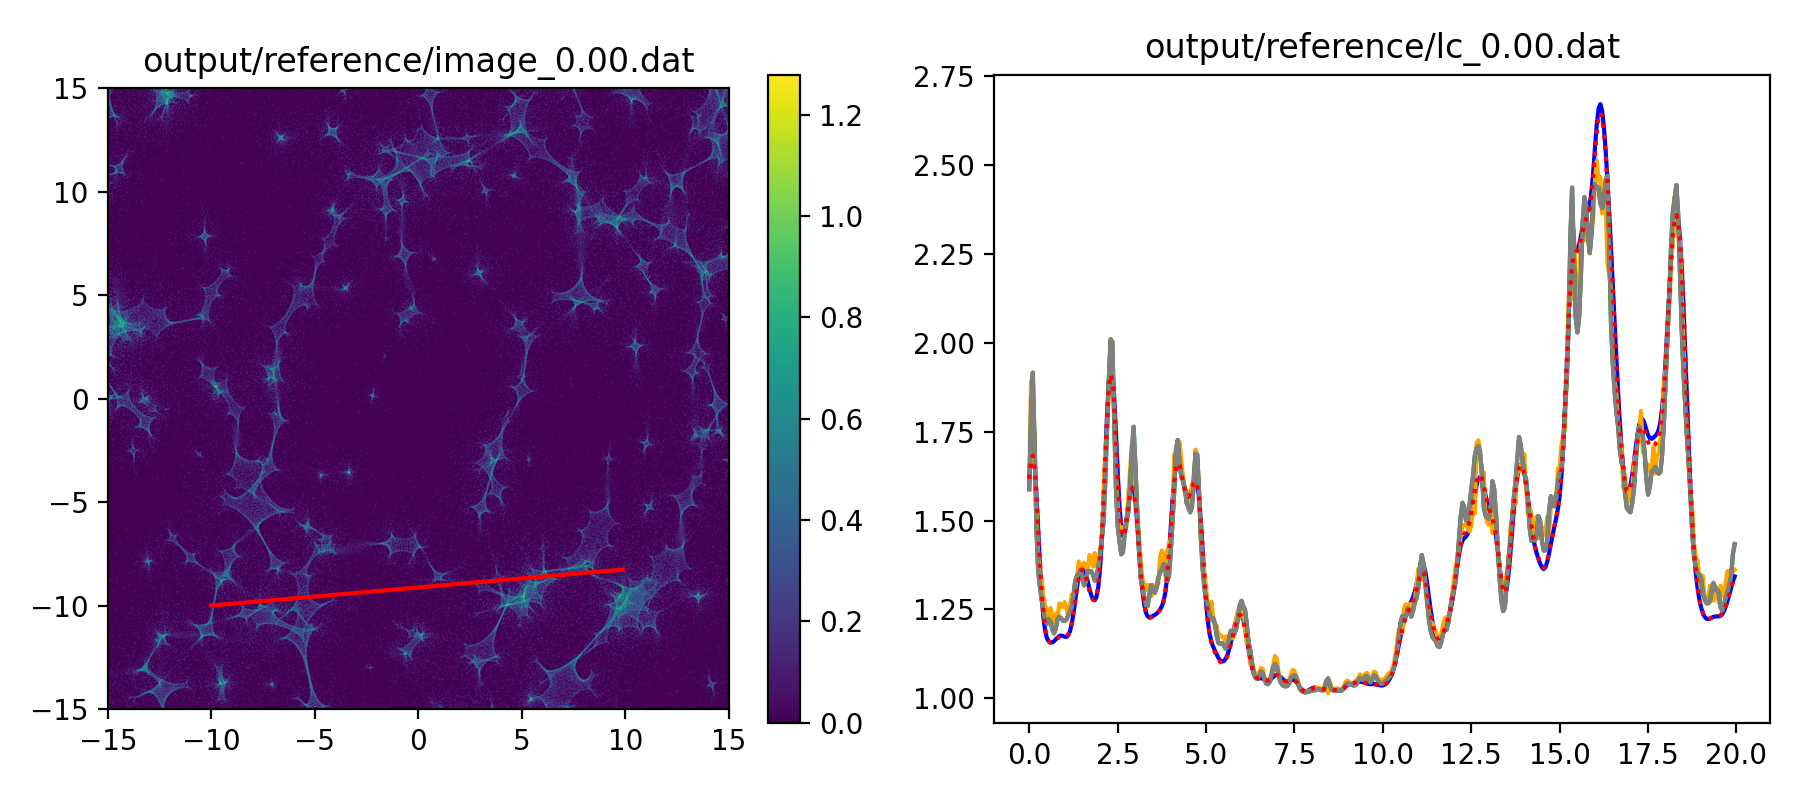

In [55]:
filename1 = "output/reference/image_0.00.dat"
filename2 = "output/reference/lc_0.00.dat"

img1, extent1 = get_image_data(filename1, logscale=True, debug=True)
lc = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
ax1.plot(lc['y1'], lc['y2'], color='red')
pos2 = ax2.plot(lc['t'], lc['a_gs'], '-', color='blue')
ax2.plot(lc['t'], lc['a_ad'], '-', color='orange')
ax2.plot(lc['t'], lc['a_pl'], '-', color='green')
ax2.plot(lc['t'], lc['a_pl'], '-', color='grey')
ax2.plot(lc['t'], lc['a_el'], '-', color='red', linestyle='dotted')
#pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
#pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.tight_layout()
plt.show()

output/reference/image_0.00.dat
	zeros: 500668 (50.0668%)
	mean & std: 0.664888 +- 0.8913977492993799
	total_rays: 664888.0


<IPython.core.display.Javascript object>


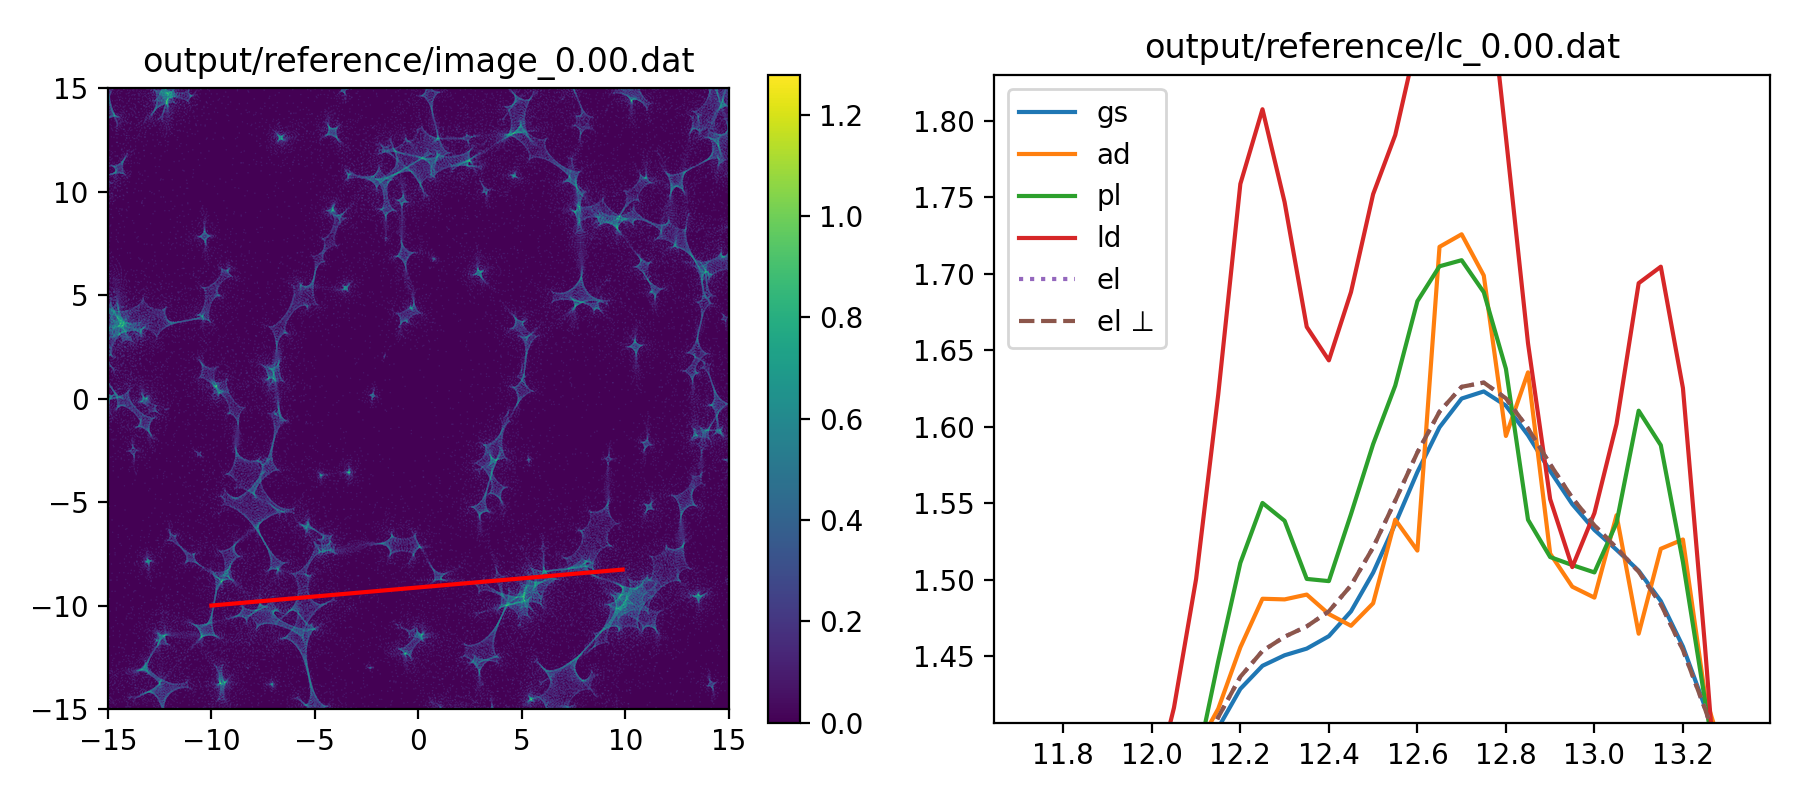

In [236]:
filename1 = "output/reference/image_0.00.dat"
filename2 = "output/reference/lc_0.00.dat"

img1, extent1 = get_image_data(filename1, logscale=True, debug=True)
lc = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
ax1.plot(lc['y1'], lc['y2'], color='red')
pos2 = ax2.plot(lc['t'], lc['a_gs'], '-', label='gs')
ax2.plot(lc['t'], lc['a_ad'], '-', label='ad')
ax2.plot(lc['t'], lc['a_pl'], '-', label='pl')
ax2.plot(lc['t'], lc['a_ld'], '-', label='ld')
ax2.plot(lc['t'], lc['a_el'], '-', linestyle='dotted', label='el')
ax2.plot(lc['t'], lc['a_el'], '-', linestyle='dashed', label='el ⊥')
ax2.legend()
#pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
#pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.tight_layout()
plt.show()

output/reference/image_0.10.dat
	zeros: 488975 (48.8975%)
	mean & std: 0.678132 +- 0.8795299827612474
	total_rays: 678132.0


<IPython.core.display.Javascript object>


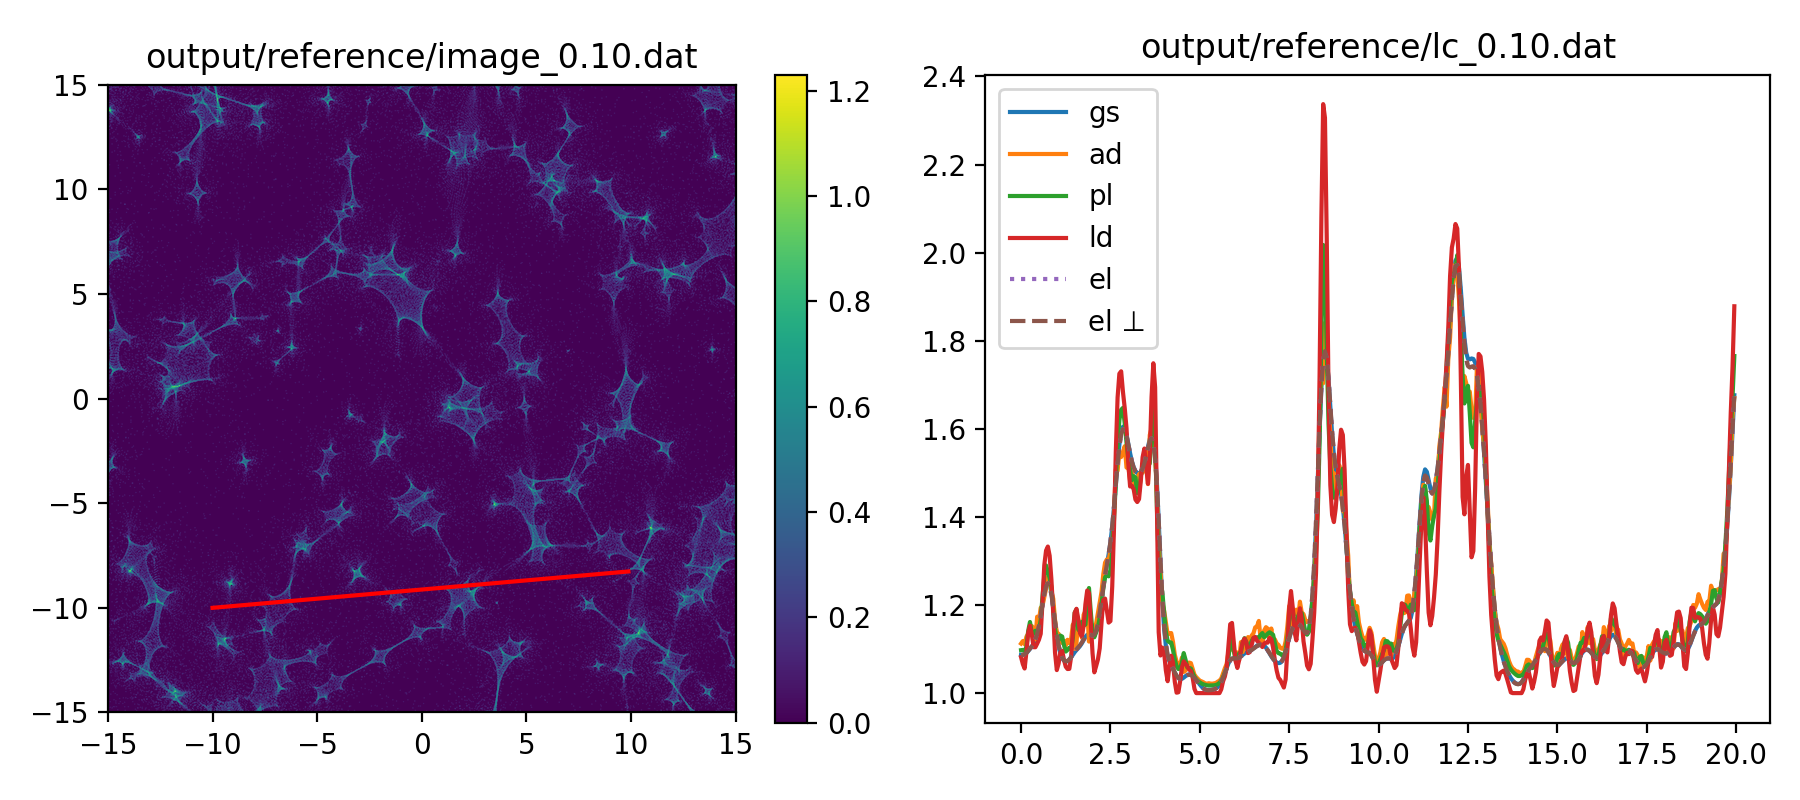

In [237]:
filename1 = "output/reference/image_0.10.dat"
filename2 = "output/reference/lc_0.10.dat"

img1, extent1 = get_image_data(filename1, logscale=True, debug=True)
lc = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
ax1.plot(lc['y1'], lc['y2'], color='red')
pos2 = ax2.plot(lc['t'], lc['a_gs'], '-', label='gs')
ax2.plot(lc['t'], lc['a_ad'], '-', label='ad')
ax2.plot(lc['t'], lc['a_pl'], '-', label='pl')
ax2.plot(lc['t'], lc['a_ld'], '-', label='ld')
ax2.plot(lc['t'], lc['a_el'], '-', linestyle='dotted', label='el')
ax2.plot(lc['t'], lc['a_el'], '-', linestyle='dashed', label='el ⊥')
ax2.legend()
#pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
#pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


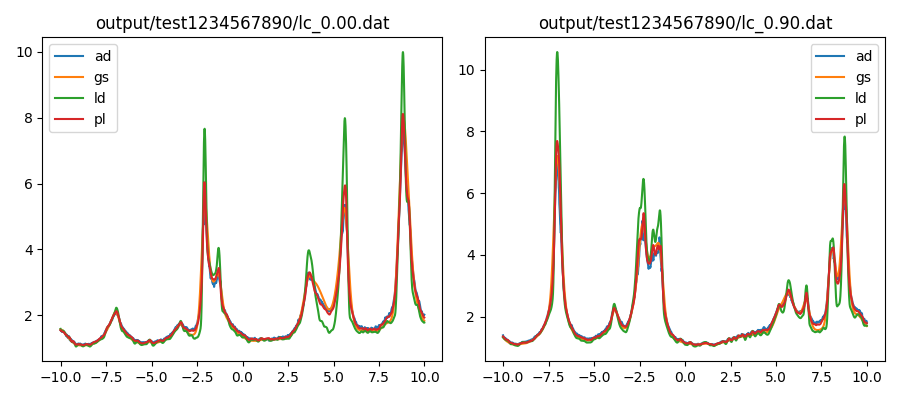

In [4]:
filename1 = "output/test1234567890/lc_0.00.dat"
filename2 = "output/test1234567890/lc_0.90.dat"

lc1 = get_lc_data(filename1)
lc2 = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.plot(lc1['y1'], lc1['a_ad']/lc1['n_ad'], '-', label='ad')
ax1.plot(lc1['y1'], lc1['a_gs']/lc1['n_gs'], '-', label='gs')
ax1.plot(lc1['y1'], lc1['a_ld']/lc1['n_ld'], '-', label='ld')
ax1.plot(lc1['y1'], lc1['a_pl']/lc1['n_pl'], '-', label='pl')
ax1.legend()

pos2 = ax2.plot(lc2['y1'], lc2['a_ad']/lc2['n_ad'], '-', label='ad')
ax2.plot(lc2['y1'], lc2['a_gs']/lc2['n_gs'], '-', label='gs')
ax2.plot(lc2['y1'], lc2['a_ld']/lc2['n_ld'], '-', label='ld')
ax2.plot(lc2['y1'], lc2['a_pl']/lc2['n_pl'], '-', label='pl')
ax2.legend()

ax1.set_title(filename1)
ax2.set_title(filename2)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


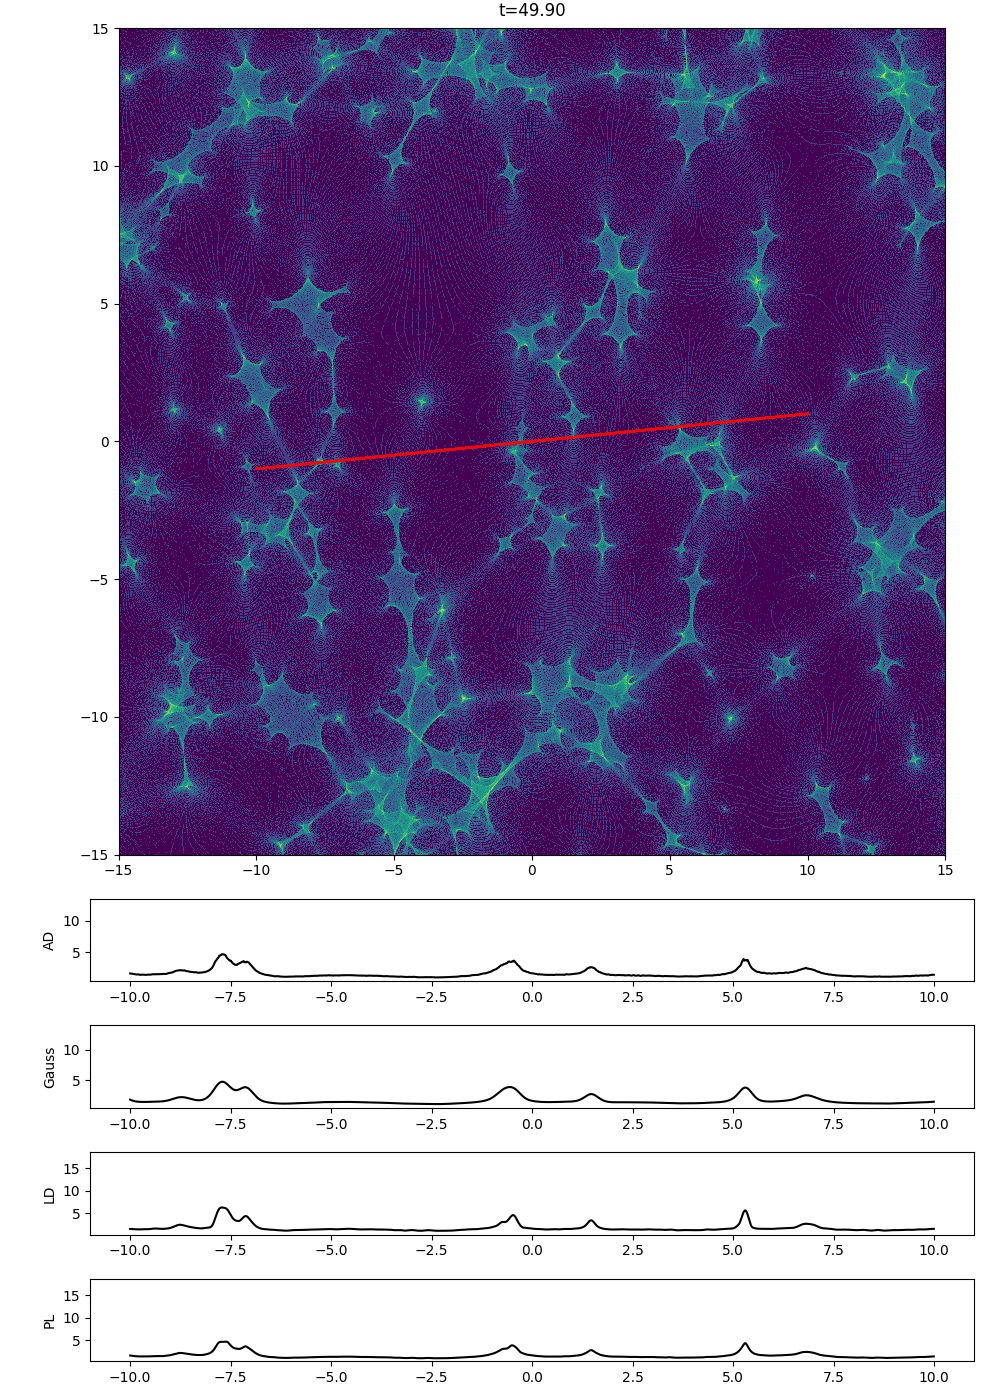

t=0.00
t=1.00
t=2.00
t=3.00
t=4.00
t=5.00
t=6.00
t=7.00
t=8.00
t=9.00
t=10.00
t=11.00
t=12.00
t=13.00
t=14.00
t=15.00
t=16.00
t=17.00
t=18.00
t=19.00
t=20.00
t=21.00
t=22.00
t=23.00
t=24.00
t=25.00
t=26.00
t=27.00
t=28.00
t=29.00
t=30.00
t=31.00
t=32.00
t=33.00
t=34.00
t=35.00
t=36.00
t=37.00
t=38.00
t=39.00
t=40.00
t=41.00
t=42.00
t=43.00
t=44.00
t=45.00
t=46.00
t=47.00
t=48.00
t=49.00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(10, 14), gridspec_kw={'height_ratios': [10, 1, 1, 1, 1]})
fig.tight_layout()
fig.subplots_adjust(left=0.09, top=0.98)

ims = []
max_ampl = []
s_ad_max = 0
s_gs_max = 0
s_ld_max = 0
s_pl_max = 0
for t in np.arange(0, 50, 0.1):
    if 10 * t % 10 == 0:
        print("t=%.2f" % t)
    filename1 = "output/test/image_%.2f.dat" % t
    filename2 = "output/test/lc_%.2f.dat" % t
    img, extent = get_image_data(filename1, logscale=True)
    lc = get_lc_data(filename2)
    title = ax1.text(0.5,1.01, "t=%.2f" % t, ha="center",va="bottom", transform=ax1.transAxes, fontsize="large")
    line1 = ax1.imshow(img, interpolation='none', extent=extent, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    
    s_ad = lc['a_ad']/lc['n_ad']
    line2, = ax2.plot(lc['y1'], s_ad, '-', color='black')
    ax2.set_ylabel('AD')
    if max(s_ad) > s_ad_max: s_ad_max = max(s_ad)
        
    s_gs = lc['a_gs']/lc['n_gs']
    line3, = ax3.plot(lc['y1'], s_gs, '-', color='black')
    ax3.set_ylabel('Gauss')
    if max(s_gs) > s_gs_max: s_gs_max = max(s_gs)

    s_ld = lc['a_ld']/lc['n_ld']
    line4, = ax4.plot(lc['y1'], s_ld, '-', color='black')
    ax4.set_ylabel('LD')
    if max(s_ld) > s_ld_max: s_ld_max = max(s_ld)

    s_pl = lc['a_pl']/lc['n_pl']
    line5, = ax5.plot(lc['y1'], s_pl, '-', color='black')
    ax5.set_ylabel('PL')
    if max(s_pl) > s_pl_max: s_pl_max = max(s_ld)

    ims.append([line1, line2, line3, line4, line5, title])

for l in ims:
    _l1, _l2, _l3, _l4, _l5, _t = l
    _l2.axes.set_ylim([None, 1.05 * s_ad_max])
    _l3.axes.set_ylim([None, 1.05 * s_gs_max])
    _l4.axes.set_ylim([None, 1.05 * s_ld_max])
    _l5.axes.set_ylim([None, 1.05 * s_pl_max])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=False)
ani.save('images/dynamic_images.mp4')
plt.show()

<IPython.core.display.Javascript object>


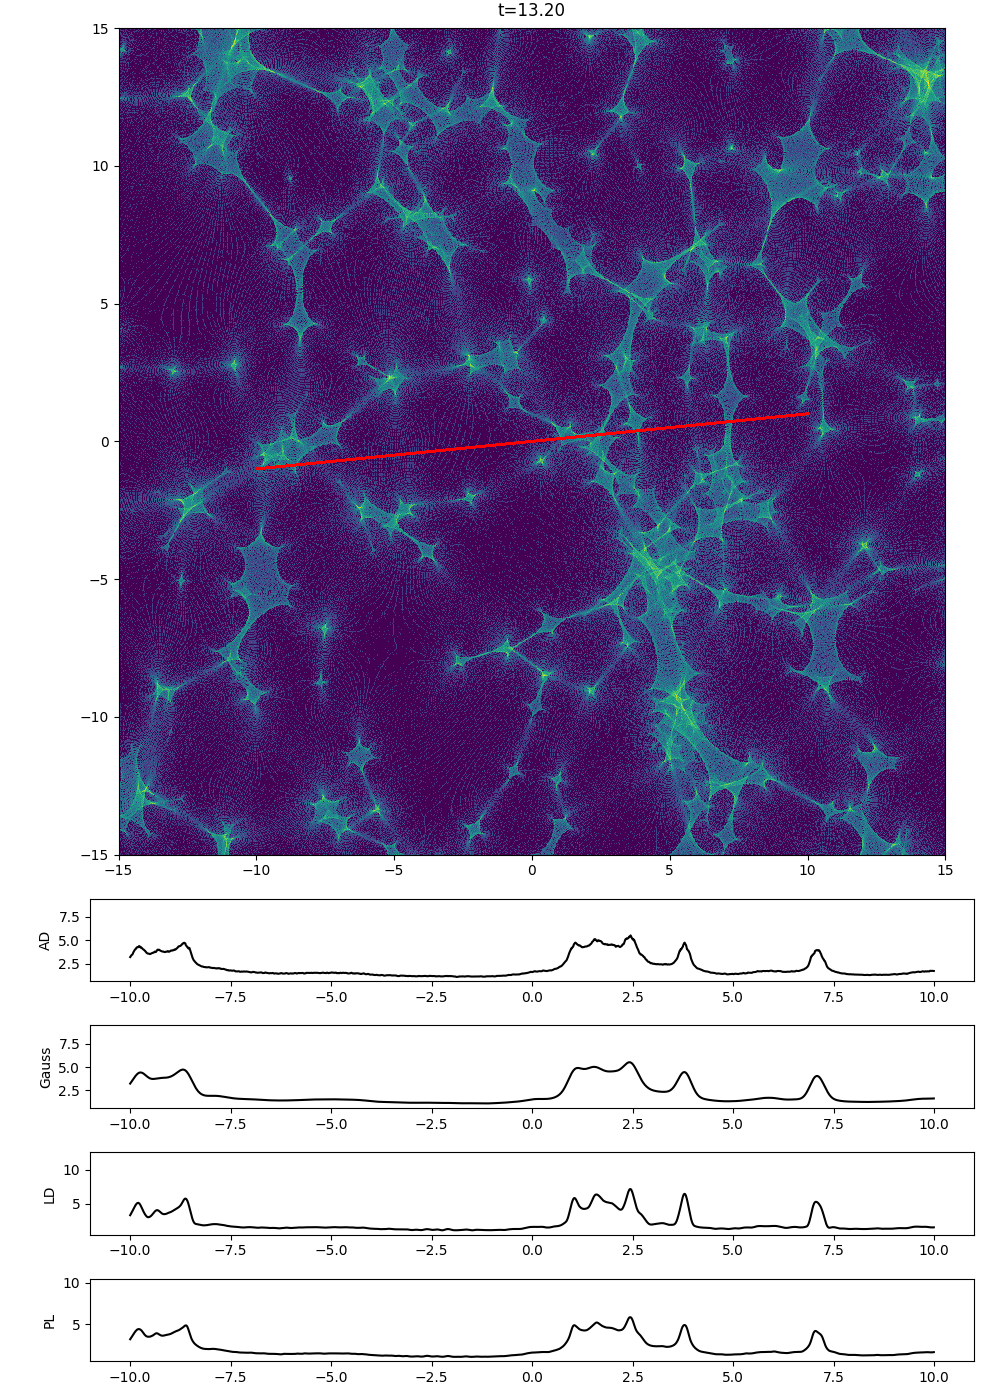

t=0.00
t=1.00
t=2.00
t=3.00
t=4.00
t=5.00
t=6.00
t=7.00
t=8.00
t=9.00
t=10.00
t=11.00
t=12.00
t=13.00
t=14.00
t=15.00
t=16.00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(10, 14), gridspec_kw={'height_ratios': [10, 1, 1, 1, 1]})
fig.tight_layout()
fig.subplots_adjust(left=0.09, top=0.98)

ims = []
max_ampl = []
s_ad_max = 0
s_gs_max = 0
s_ld_max = 0
s_pl_max = 0
for t in np.arange(0, 17, 0.1):
    if 10 * t % 10 == 0:
        print("t=%.2f" % t)
    filename1 = "output/test1234567890/image_%.2f.dat" % t
    filename2 = "output/test1234567890/lc_%.2f.dat" % t
    img, extent = get_image_data(filename1, logscale=True)
    lc = get_lc_data(filename2)
    title = ax1.text(0.5,1.01, "t=%.2f" % t, ha="center",va="bottom", transform=ax1.transAxes, fontsize="large")
    line1 = ax1.imshow(img, interpolation='none', extent=extent, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    
    s_ad = lc['a_ad']/lc['n_ad']
    line2, = ax2.plot(lc['y1'], s_ad, '-', color='black')
    ax2.set_ylabel('AD')
    if max(s_ad) > s_ad_max: s_ad_max = max(s_ad)
        
    s_gs = lc['a_gs']/lc['n_gs']
    line3, = ax3.plot(lc['y1'], s_gs, '-', color='black')
    ax3.set_ylabel('Gauss')
    if max(s_gs) > s_gs_max: s_gs_max = max(s_gs)

    s_ld = lc['a_ld']/lc['n_ld']
    line4, = ax4.plot(lc['y1'], s_ld, '-', color='black')
    ax4.set_ylabel('LD')
    if max(s_ld) > s_ld_max: s_ld_max = max(s_ld)

    s_pl = lc['a_pl']/lc['n_pl']
    line5, = ax5.plot(lc['y1'], s_pl, '-', color='black')
    ax5.set_ylabel('PL')
    if max(s_pl) > s_pl_max: s_pl_max = max(s_ld)

    ims.append([line1, line2, line3, line4, line5, title])

for l in ims:
    _l1, _l2, _l3, _l4, _l5, _t = l
    _l2.axes.set_ylim([None, 1.05 * s_ad_max])
    _l3.axes.set_ylim([None, 1.05 * s_gs_max])
    _l4.axes.set_ylim([None, 1.05 * s_ld_max])
    _l5.axes.set_ylim([None, 1.05 * s_pl_max])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=False)
ani.save('images/dynamic_images123.mp4')
plt.show()

<IPython.core.display.Javascript object>


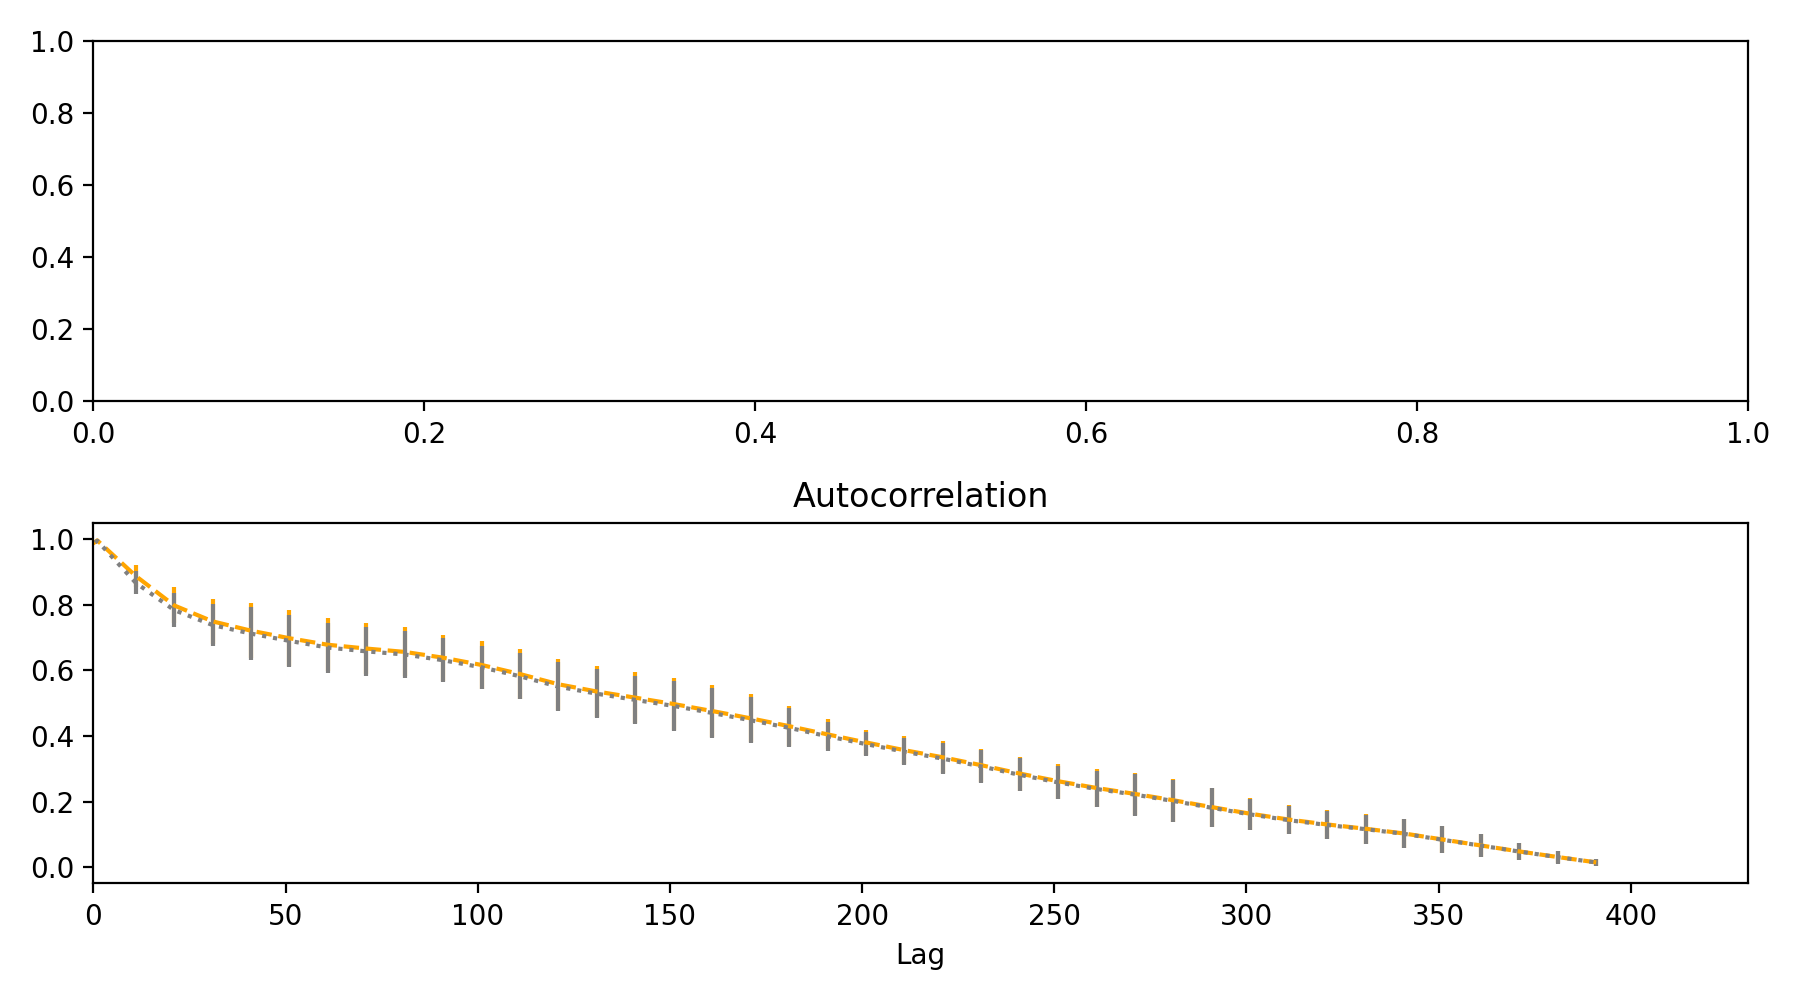

In [102]:
from scipy import signal

colors = {
    'ad' : 'blue',
    'gs' : 'orange',
    'ld' : 'green',
    'pl' : 'red',
    'el' : 'orange',
    'el_orth' : 'grey',
}

lines = {
    'ad' : None,
    'gs' : None,
    'ld' : None,
    'pl' : None,
    'el' : 'dashed',
    'el_orth' : 'dotted',  
}

fig, (ax_orig, ax_corr) = plt.subplots(2, 1, figsize=(9, 5))

lags = None
ay = {}

for t in np.arange(0, 50, 0.1):
    filename2 = "output/e0.5/lc_%.2f.dat" % t
    img, extent = get_image_data(filename1, logscale=True)
    lc = get_lc_data(filename2)
    
    for i in ['el', 'el_orth']:
        sig1 = lc['a_%s' % i]
        sig2 = lc['a_%s' % i]

        corr = signal.correlate(sig1, sig2)
        lags = signal.correlation_lags(len(sig1), len(sig2))
        corr /= np.max(corr)
        if i not in ay:
            ay[i] = []
        ay[i].append(corr)    
        
        #ax_orig.plot(sig1, color=colors[i])
        #ax_orig.set_title('LCs')

        #ax_corr.plot(lags, corr, color=colors[i], linestyle=lines[i])
        #ax_corr.set_title('Autocorrelation')
        #ax_corr.set_xlabel('Lag')
        #ax_corr.set_xlim([0, None])

ax_corr.errorbar(lags[::10], y=np.mean(ay['el'], axis=0)[::10], yerr=np.std(ay['el'], axis=0)[::10], color=colors['el'], linestyle=lines['el'])
ax_corr.errorbar(lags[::10], y=np.mean(ay['el_orth'], axis=0)[::10], yerr=np.std(ay['el_orth'], axis=0)[::10], color=colors['el_orth'], linestyle=lines['el_orth'])
ax_corr.set_title('Autocorrelation')
ax_corr.set_xlabel('Lag')
ax_corr.set_xlim([0, None])        
        
fig.tight_layout()
plt.show()




In [206]:
def cross_corr(t, y1, y2):
    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    #corr = np.correlate(y1, y2, mode='same')
    #unbiased_sample_size = np.correlate(np.ones(len(y1)), np.ones(len(y1)), mode='same')
    corr = signal.correlate(y1, y2)
    unbiased_sample_size = signal.correlate(np.ones(len(y1)), np.ones(len(y1)))
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    res = corr[(len(corr) // 2) : len(corr)]
    return res, t.to_numpy()[:len(res)]

In [221]:
from matplotlib.pyplot import cm
colors = iter(cm.rainbow(np.linspace(0, 1, 400)))

<IPython.core.display.Javascript object>


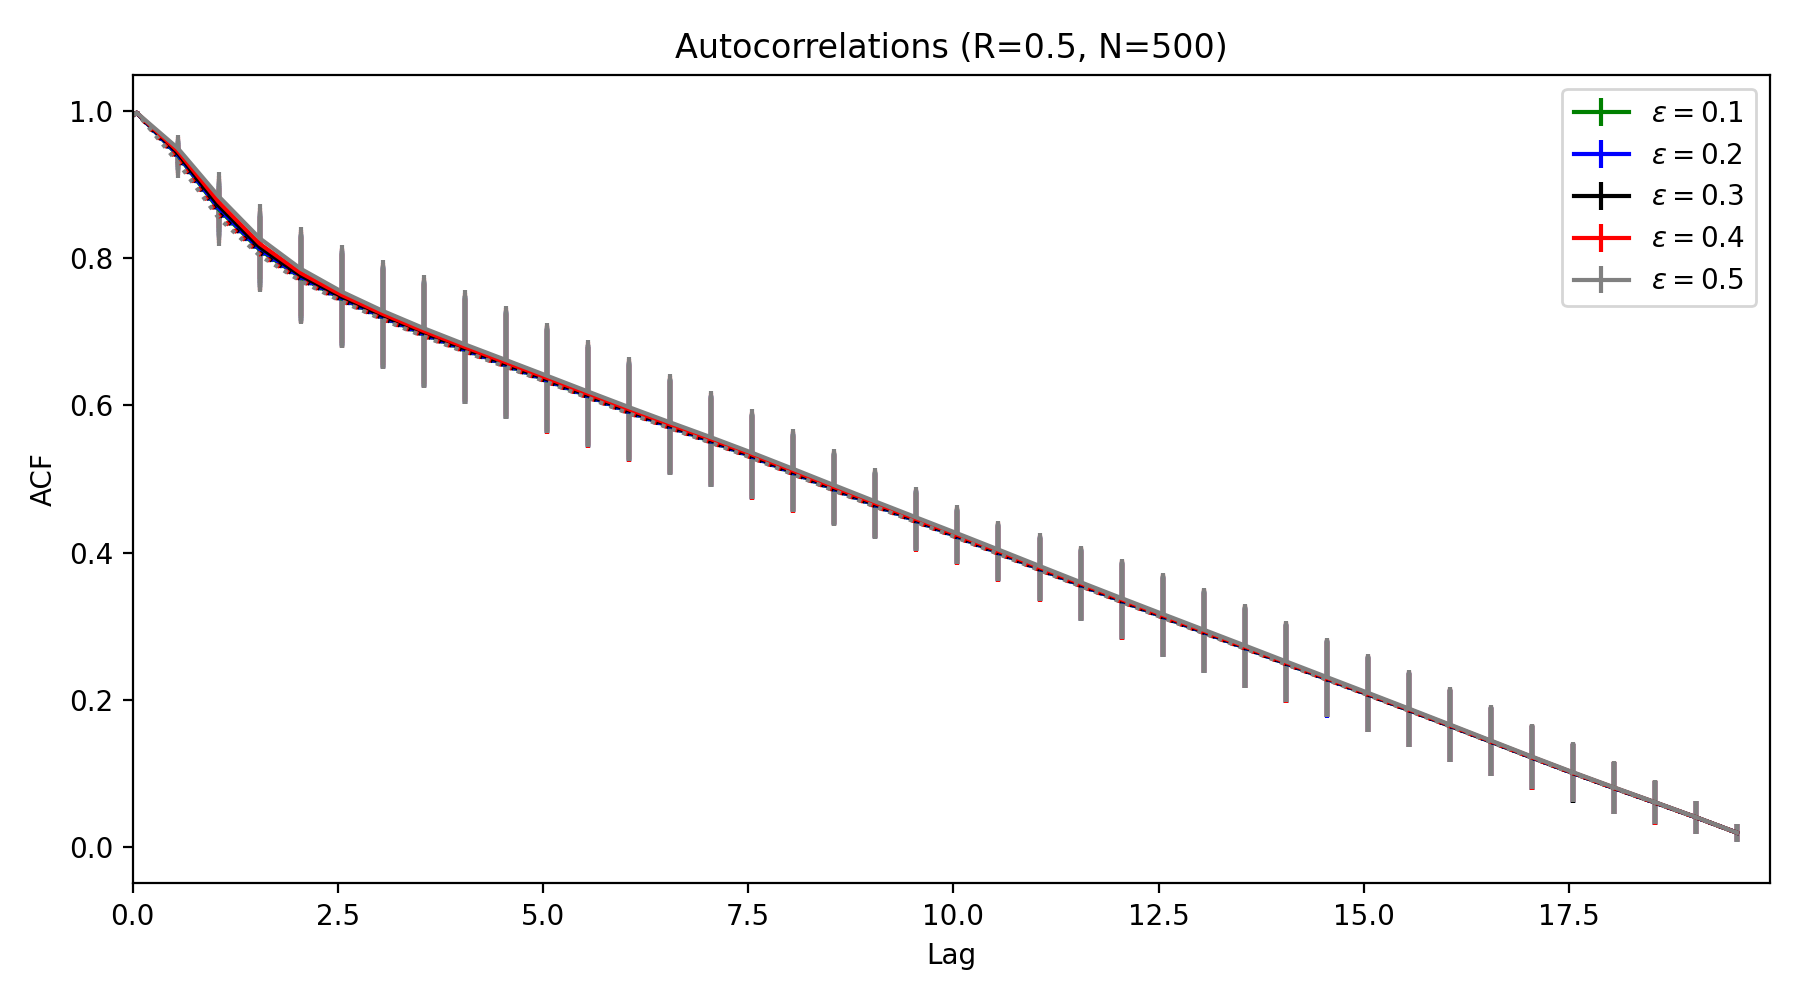

In [241]:
from scipy import signal
import matplotlib.colors as mcolors

fig, ax_corr = plt.subplots(1, 1, figsize=(9, 5))

lags = None
lags1 = None

colors = [
    "green",
    "blue",
    "black",
    "red",
    "grey",
    "orange",
    "purple"
]

index = 0
for e in ['0.1', '0.2', '0.3', '0.4', '0.5']:
    a1 = []
    a2 = []
    
    a3 = []
    a4 = []
    for t in np.arange(0, 50, 0.1):
        filename2 = "output/e%s_r0.5/lc_%.2f.dat" % (e, t)
        lc = get_lc_data(filename2)

        tc = lc['t']
        sig1 = lc['a_el']
        sig2 = lc['a_el_orth']

        corr1, lags = cross_corr(tc, sig1, sig1)
        corr2, lags = cross_corr(tc, sig2, sig2)
        
        a1.append(corr1)
        a2.append(corr2)

        c1 = signal.correlate(sig1, sig1)
        c2 = signal.correlate(sig2, sig2)
        c1 /= np.max(c1)
        c2 /= np.max(c2)
        
        lags1 = signal.correlation_lags(len(sig1), len(sig2)) * (tc[1] - tc[0])
        a3.append(c1)
        a4.append(c2)
    
    c = colors[index]
    
    #ax_corr.errorbar(lags[::10], y=np.mean(a1, axis=0)[::10], yerr=0*np.std(a1, axis=0)[::10], c=c, label=e)
    #ax_corr.errorbar(lags[::10], y=np.mean(a2, axis=0)[::10], yerr=0*np.std(a2, axis=0)[::10], c=c, linestyle='dashed')

    ax_corr.errorbar(lags1[::10], y=np.mean(a3, axis=0)[::10], yerr=np.std(a3, axis=0)[::10], c=c, label='$\epsilon = %s$' % e)
    ax_corr.errorbar(lags1[::10], y=np.mean(a4, axis=0)[::10], yerr=np.std(a4, axis=0)[::10], c=c, linestyle='dotted')

    index+=1
ax_corr.set_title('Autocorrelations (R=0.5, N=500)')
ax_corr.set_xlabel('Lag')
ax_corr.set_ylabel('ACF')
ax_corr.set_xlim([0, max(lags)])        
ax_corr.legend()
fig.tight_layout()
plt.show()




<IPython.core.display.Javascript object>


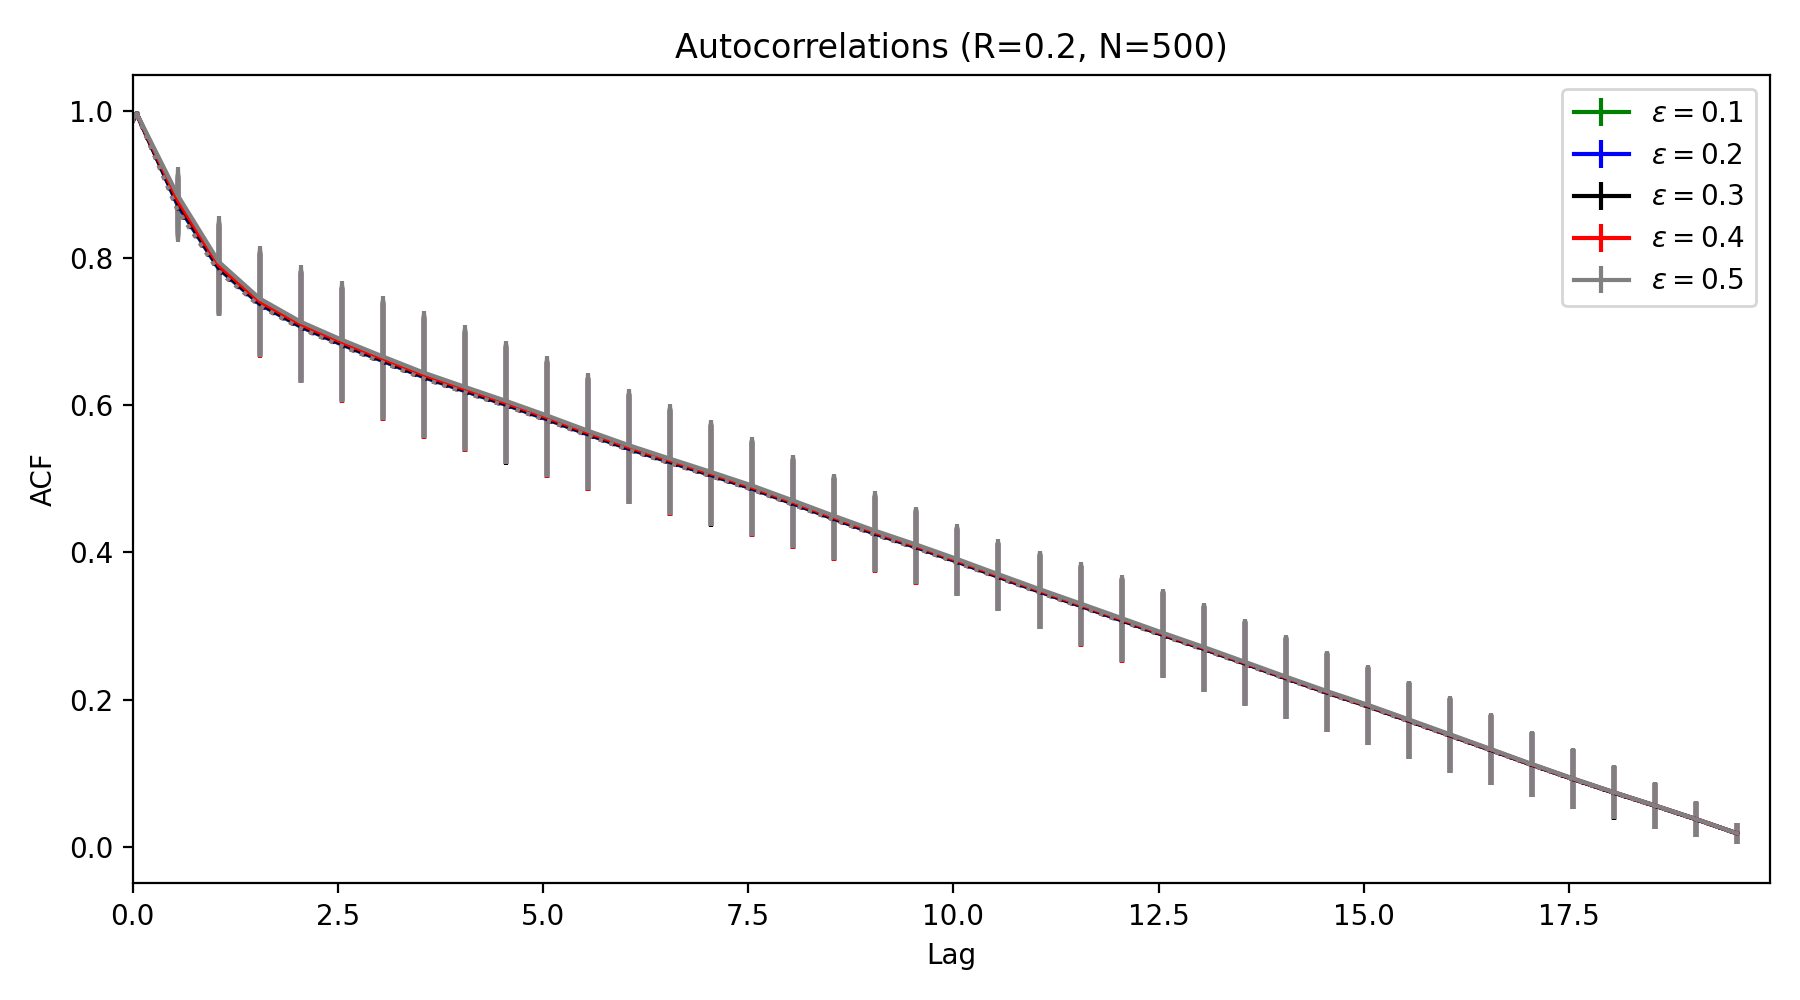

In [242]:
from scipy import signal
import matplotlib.colors as mcolors

fig, ax_corr = plt.subplots(1, 1, figsize=(9, 5))

lags = None
lags1 = None

colors = [
    "green",
    "blue",
    "black",
    "red",
    "grey",
    "orange",
    "purple"
]

index = 0
for e in ['0.1', '0.2', '0.3', '0.4', '0.5']:
    a1 = []
    a2 = []
    
    a3 = []
    a4 = []
    for t in np.arange(0, 50, 0.1):
        filename2 = "output/e%s_r0.2/lc_%.2f.dat" % (e, t)
        lc = get_lc_data(filename2)

        tc = lc['t']
        sig1 = lc['a_el']
        sig2 = lc['a_el_orth']

        corr1, lags = cross_corr(tc, sig1, sig1)
        corr2, lags = cross_corr(tc, sig2, sig2)
        
        a1.append(corr1)
        a2.append(corr2)

        c1 = signal.correlate(sig1, sig1)
        c2 = signal.correlate(sig2, sig2)
        c1 /= np.max(c1)
        c2 /= np.max(c2)
        
        lags1 = signal.correlation_lags(len(sig1), len(sig2)) * (tc[1] - tc[0])
        a3.append(c1)
        a4.append(c2)
    
    c = colors[index]
    
    #ax_corr.errorbar(lags[::10], y=np.mean(a1, axis=0)[::10], yerr=0*np.std(a1, axis=0)[::10], c=c, label=e)
    #ax_corr.errorbar(lags[::10], y=np.mean(a2, axis=0)[::10], yerr=0*np.std(a2, axis=0)[::10], c=c, linestyle='dashed')

    ax_corr.errorbar(lags1[::10], y=np.mean(a3, axis=0)[::10], yerr=np.std(a3, axis=0)[::10], c=c, label='$\epsilon = %s$' % e)
    ax_corr.errorbar(lags1[::10], y=np.mean(a4, axis=0)[::10], yerr=np.std(a4, axis=0)[::10], c=c, linestyle='dotted')

    index+=1
ax_corr.set_title('Autocorrelations (R=0.2, N=500)')
ax_corr.set_xlabel('Lag')
ax_corr.set_ylabel('ACF')
ax_corr.set_xlim([0, max(lags)])        
ax_corr.legend()
fig.tight_layout()
plt.show()




In [ ]:
import os
import numpy as np
from numpy import arange
from numpy import zeros
from numpy import absolute as abs
from numpy import square
from numpy import real
from numpy import sqrt
from numpy import exp
from numpy import concatenate as cat
from numpy import conjugate as conj
from numpy.fft import fft
from numpy.fft import ifft
from math import pi

def lewis_ccor (navigt, templt, N, Q, M, P):
    cc = zeros(P)      # normalized cross-correlation
    ns = zeros(N+1)    # navigator sum
    ns2 = zeros(N+1)   # navigator sum of squares
    for i in range(N):
        a = navigt [i]
        ns [i + 1] = a + ns [i]
        ns2 [i + 1] = a*a + ns2 [i]

    q = Q-1
    template = templt [q:q+M]
    ts = sum(template)               # template sum
    ts2 = sum(square(template))    # template sum of squares
    tm = ts/M                     # template mean
    tv = ts2 − square(ts)/M       # template variance
    v1 = template − tm

    for i in range(P):
        k = i+M
        A = ns [k] − ns [i]

       C = ns2 [k] − ns2 [i]

       nm = A/M

       nv = C − A*A/M

       v2 = navigator [i:k] − nm

       numerator = sum(v1*v2)

       denominator = sqrt(tv*nv)

       cc [i] = numerator/denominator

    return cc

def luo_ccor (navigt, templt, N, Q, M, P):

    cc = zeros(P)  # normalized cross-correlation

    ns = zeros(N+1)    # navigator sum

    ns2 = zeros(N+1)   # navigator sum of squares

    tns = zeros((N+1,N))   # template-navigator cross terms

    for i in range(N):

       a = navigt [i]

       ns [i + 1] = a + ns [i]

       ns2 [i + 1] = a*a + ns2 [i]

       for d in range(N):

         k = (i+d)%N

         tns [i + 1] [d] = tns [i] [d] + templt [i]*navigt [k]

    q = Q-1

    template = templt [q:q+M]

    ts = sum(template)               # template sum

    ts2 = sum(square(template))    # template sum of squares

    tm = ts/M                     # template mean

    tv = ts2 − square(ts)/M       # template variance

    for i in range(P):

       k = i+M

       A = ns [k] − ns [i]

       C = ns2 [k] − ns2 [i]

       nv = C − A*A/M

       d = (i-q)%N

       numerator = (tns [q+M,d] − tns [q,d]) − A*tm

       denominator = sqrt(tv*nv)

       cc [i] = numerator/denominator

    return cc

def template_functions (templt, kernel, N, Q, M, P):

    templt2 = square(abs(templt))

    tmp = ifft(fft(templt)*kernel)

    gc = tmp [range(P)]

    tmp = ifft(fft(templt2)*kernel)

    gg = real(tmp [range(P)])

    templt_padded = cat((templt [Q-1:Q+M-1],zeros(N-M)))

    FTpg = fft(templt_padded)/M

    return gc, gg, FTpg

def complex_ccor (navigt, gc, gg, kernel, FTpg, N, Q, M, P):
    navigt2 = square(abs(navigt))
    tmp = ifft(fft(navigt)*kernel)
    fc = tmp [range(P)]
    tmp = ifft(fft(navigt2)*kernel)
    ff = real(tmp [range(P)])
    FTnv = fft(navigt)
    tmp = fft(conj(FTnv)*FTpg)/N
    fgc = tmp [range(P)]
    q = Q-1
    gcq = gc [q]
    ggq = gg [q]
    numerator = real(fgc − conj(fc)*gcq)
    denominator = sqrt((ff − square(abs(fc)))*(ggq − square(abs(gcq))))
    return numerator/denominator

if __name__ == ‘__main__’:

    tx1 = 80

    tx2 = 106

    n = 128

    q = tx1

    m = tx2-tx1+1

    p = n-m+1

    A = np.fromfile(“navigators.dat”, sep=“\t”).reshape(n,3)

    template = []

    navigator = []

    for i in range(n):

       template = template + [A [i] [1]]

       navigator = navigator + [A [i] [2]]

    k = arange(1,n)

    kernel = (1.0/m) * ((exp(1 j * 2 * pi * m * k/n) − 1)/(exp(1 j * 2 * pi * k/n) − 1))

    kernel = cat(([1 + 1 j * 0.0], kernel))

    gc, gg, FTpg = template_functions(template, kernel, n, q, m, p)

    cc = complex_ccor(navigator, gc, gg, kernel, FTpg, n, q, m, p)

    lewis_cc = lewis_ccor(navigator, template, n, q, m, p)

    luo_cc = luo_ccor(navigator, template, n, q, m, p)